# Dynamic Portfolios

and intertemporal hedging in a simple discrete time model.

## Load Packages and Extra Functions

In [1]:
using Printf, LinearAlgebra
include("src/printmat.jl");

using Plots, LaTeXStrings
default(size = (480,320),fmt = :png)

# Log Utility

We first find the *myopic* (period by period) optimal portfolio when the investor has log utility,

$U(R_p) = \ln (1+R_p),$

where $R_p$ is the portfolio return.

In all examples discussed below, the log returns are normally distributed, but the vector of *expected* returns changes across time. In particular, the vector of expected returns take on two different values (state A and state B).

In [2]:
"""
Calculate optimal portfolio for log utility case, when the log returns are N(μe+rf,Σ),
Campbell&Viceira.
"""
function OptPortLogUtil(Σ,μe,rf)
  v     = inv(Σ)*(μe+diag(Σ)/2)
  Erp   = rf + v'μe + v'diag(Σ)/2 - v'Σ*v/2
  Varrp = v'Σ*v
  return v, Erp, Varrp
end

OptPortLogUtil

In [3]:
Σ  = [83  17  29;              #3 risky assets
      17  32   2;
      29   2  50]/10000
μeA = [0.8, 0.9, 0.3]/100       #expected excess returns in state A
μeB = [0.4, 0.45, 0.15]/100     #expected excess returns in state B

vA, = OptPortLogUtil(Σ,μeA,0)  #myopic portfolio choice in each state
vB, = OptPortLogUtil(Σ,μeB,0)

printblue("Portfolio weights in the two states (several risky assets):")
rowNames3 = ["asset 1","asset 2","asset 3","riskfree"]
printmat([vA vB;1-sum(vA) 1-sum(vB)];colNames=["state A","state B"],rowNames=rowNames3,prec=2)

Portfolio weights in the two states (several risky assets):
           state A   state B
asset 1       0.65      0.49
asset 2       2.93      1.62
asset 3       0.60      0.45
riskfree     -3.18     -1.56



# CRRA Utility

We now turn to the *myopic* (period by period) optimal portfolio when the investor has CRRA utility

$U(R_p) = (1+R_p)^{1-\gamma}/(1-\gamma),$

where $R_p$ is the portfolio return. As $\gamma \rightarrow 1$, this becomes the same as log utility (need to take the limit to prove that).

In [4]:
"""
Calculate optimal portfolio for CRRA utility case, when the log returns are N(μe+rf,Σ),
Campbell&Viceira.
"""
function OptPortCRRA(Σ,μe,rf,γ)
  v     = inv(Σ)*(μe+diag(Σ)/2)/γ
  Erp   = rf + v'μe + v'diag(Σ)/2 - v'Σ*v/2
  Varrp = v'Σ*v
  return v, Erp, Varrp
end

OptPortCRRA

In [5]:
γ = 6

vA, = OptPortCRRA(Σ,μeA,0,γ)              #with several risky assets
vB, = OptPortCRRA(Σ,μeB,0,γ)

printblue("Portfolio weights in the two states (several risky assets):")
printmat([vA vB;1-sum(vA) 1-sum(vB)];colNames=["state A","state B"],rowNames=rowNames3,prec=2)

Portfolio weights in the two states (several risky assets):
           state A   state B
asset 1       0.11      0.08
asset 2       0.49      0.27
asset 3       0.10      0.07
riskfree      0.30      0.57



# Intertemporal Hedging

We now consider the more difficult case when the CRRA investor considers several periods. 

In the case of log utility ($\gamma=1$), this actually gives a myopic solution: in each period, $\ln(1+R_p$) is maximized, where $R_p$ is the one period portfolio return.

With CRRA this may no longer hold. In particular, if there are some predictable (non-iid) features of the asset returns, then today's investment may be influenced by how the return over the next period is correlated with the investment opportunities in the subsequent periods.

The optimal solution used in the next few cells (see lecture notes for details) is for the case when the vector ($n$ assets) of excess returns follow

$r_{t+1}^{e}=a+z_{t}+u_{t+1},$

where the vector $z_t$ follows the VAR(1)

$z_{t+1}=\phi z_{t}+\eta_{t+1},$
with $\eta_{t+1}$ being $N(\mathbf{0},\Sigma_{\eta})$.

The covariance matrix of $u_{t+1}$ and $\eta_{t+1}$, which plays a key role of the analysis, is denoted by $\Sigma_{u\eta}$.

Notice that the first equation implies that *(a)* returns are predictable, that is, the expected returns change over time; *(b)* and that those expectations potentially correlates with today's return. This may lead to *intertemporal hedging*, where the portfolio weights for an investment between $t$ and $t+1$ is affected by how the return in $t+1$ correlates with the investment oppurtunity set in $t+1$, that is, with the return distribution in $t+2$.

The next cell solves the three optimization problems (myopic, no rebalancing, rebalancing) as in the lecture notes.

In [6]:
function CRRAPortOpt(Σ_uu::Number,Σ_ηη::Number,z::Number,a::Number,ϕ::Number,θ::Number,γ)
  v_myop  = inv(Σ_uu)*(a + z + Σ_uu/2)/γ
  Σ₂      = Σ_uu*(2+2*θ+θ^2) + Σ_ηη         #for (r₁+r₂)
  v_noreb = inv(Σ₂)*(2*a + (1+ϕ)*z + Σ₂/2)/γ
  Ev1     = inv(Σ_uu)*(a + ϕ*z + Σ_uu/2)/γ
  v_rebal = inv(Σ_uu)*(a + z + Σ_uu/2 + (1-γ)*Σ_uu*θ*Ev1)/γ
  return v_myop, v_noreb, v_rebal, Σ₂
end

function CRRAPortOpt(Σ_uu::Matrix,Σ_ηη::Matrix,z::Vector,a::Vector,ϕ::Matrix,θ::Matrix,γ)
  v_myop  = inv(Σ_uu)*(a + z + diag(Σ_uu)/2)/γ
  Σ₂      = 2*Σ_uu*(I+θ') + θ*Σ_uu*θ' + Σ_ηη      #for (r₁+r₂)
  v_noreb = inv(Σ₂)*(2*a +(I+ϕ)*z + diag(Σ₂)/2)/γ
  Ev1     = inv(Σ_uu)*(a + ϕ*z + diag(Σ_uu)/2)/γ
  v_rebal = inv(Σ_uu)*(a + z + diag(Σ_uu)/2 + (1-γ)*Σ_uu*θ'*Ev1)/γ
  return v_myop, v_noreb, v_rebal, Σ₂
end

CRRAPortOpt (generic function with 2 methods)

## A Single Risky Asset 

and a riskfree. 

The next cell calculates the portfolio weight on the risky asset (in the myopic case, the 2-period investor with no rebalancing and the 2-period investor with rebalancing), for different values of the mean reversion coefficient $\theta$.

In [7]:
(ϕ,Σ_uu,Σ_ηη,a,γ) = (0,0.05^2,0.02^2,0.8/100,6)     #parameters in example with one risky asset

L = 51
θM = range(-0.5,0.5,length=L)

(v_myopH,v_norebH,v_rebH) = [fill(NaN,L) for i in 1:3]
for (i,θ) in enumerate(θM)
  (v_myopH[i],v_norebH[i],v_rebH[i],_) = CRRAPortOpt(Σ_uu,Σ_ηη,0,a,ϕ,θ,γ)
end

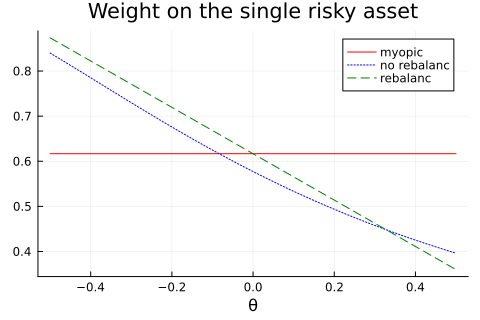

In [8]:
plot(θM,hcat(v_myopH,v_norebH,v_rebH),
     linestyle = [:solid :dot :dash],
     linecolor = [:red :blue :green],
     title = "Weight on the single risky asset",
     xlabel = "θ",
     label  = ["myopic" "no rebalanc" "rebalanc"] )

## Several Risky Assets

and a riskfree.

The next cells specify the parameter values, solves for optimal portfolio weights (in the myopic case, the 2-period investor with no rebalancing and the 2-period investor with rebalancing) for different values of $\theta_2$.

In [9]:

Σ_uu = [ 83  17  29;                              #parameter values
         17  32   2;
         29   2 50]/10_000
Σ_ηη = diagm([0,0.02^2,0])

a = [0.8,0.9,0.3]/100
ϕ = diagm([0,0.25,0])
θ = diagm([0,-0.5,0]);

In [10]:
(v_myop,v_noreb,v_reb) = [fill(NaN,L,3) for i in 1:3]
for (i,θᵢ) in enumerate(θM)
  local θMᵢ
  θMᵢ = diagm([0,θᵢ,0])
  (v_myop[i,:],v_noreb[i,:],v_reb[i,:],)  = CRRAPortOpt(Σ_uu,Σ_ηη,zeros(3),a,ϕ,θMᵢ,γ)
end

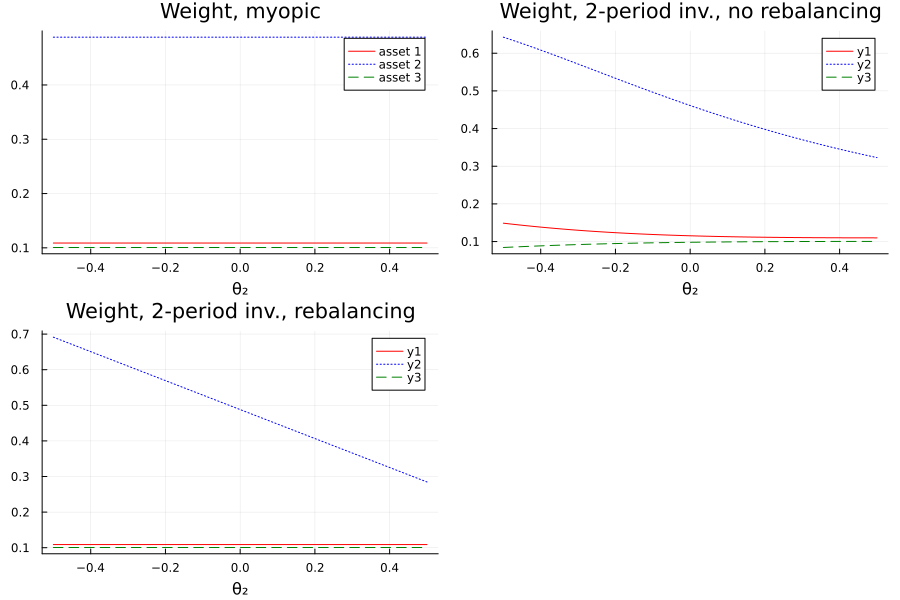

In [11]:
labels = string.("asset ",(1:3)')

p1 = plot( θM,v_myop,
           linestyle = [:solid :dot :dash],
           linecolor = [:red :blue :green],
           title = "Weight, myopic",
           xlabel = "θ₂",
           label  = labels )


p2 = plot( θM,v_noreb,
           linestyle = [:solid :dot :dash],
           linecolor = [:red :blue :green],
           title = "Weight, 2-period inv., no rebalancing",
           xlabel = "θ₂")

p3 = plot( θM,v_reb,
           linestyle = [:solid :dot :dash],
           linecolor = [:red :blue :green],
           title = "Weight, 2-period inv., rebalancing",
           xlabel = "θ₂")

pAll = plot( p1,p2,p3,                    #combine the subplots
             layout = @layout[a a;a _],
             size = (600*1.5,400*1.5) )
display(pAll)